<a href="https://colab.research.google.com/github/ethan-yoo/2022_GoingDeeper/blob/main/%5CGD_01%5CGD01_Making_SentencePiece_Dict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GDPR_01. 네이버 영화리뷰 감성분석(feat. SentencePiece)**

## **INDEX**

00. 필요한 모듈 가져오기

01. 데이터 가져오기

02. 데이터 전처리

03. Sentencepiece 학습

04. Tokenizer 생성

05. nsmc 학습

06. 모델 train & test

07. 다각도 성능 비교 분석

08. 회고

## **00. 필요한 모듈 가져오기**

In [ ]:
# !pip install konlpy
# !pip install sentencepiece

In [ ]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk 
# !pip3 install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from konlpy.tag import Mecab
import sentencepiece as spm
from sklearn.model_selection import train_test_split as tts

from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

print("Done!")

Done!


---

## **01. 데이터 가져오기**

> 데이터 출처 | [네이버 영화분석 태스크](https://github.com/e9t/nsmc)

In [66]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [67]:
data_path = '/content/mydrive/MyDrive/AIFFEL/GoingDeeper/GD01~02/nsmc/ratings.txt'

raw = pd.read_table(data_path)

print("Data size: ", len(raw))

Data size:  200000


In [68]:
raw.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


---

## **02. 데이터 전처리**

In [69]:
max_len = 0
min_len = 999
sum_len = 0

raw_docs = raw['document']

# data set analysis
for sen in raw_docs:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이: ", min_len)
print("문장의 최장 길이: ", max_len)
print("문장의 평균 길이: ", sum_len/len(raw_docs))

TypeError: ignored

문장의 길이가 float인 라인이 있습니다.

In [70]:
def check_sentence_with_type(raw):
    count = 0
    for sen in raw:
        if type(sen) == float:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_type(raw['document'])

nan
nan
nan
nan
nan
nan
nan
nan


결측치는 float 타입으로 지정되기 때문에 문제가 생기네요. 지워줍니다.

하는 김에 중복 행도 제거합니다.

In [71]:
rm_nan = raw.dropna(how='any')
len(rm_nan)

199992

In [72]:
rm_dup = rm_nan.drop_duplicates(['document'])
rm_dup = rm_dup[~rm_dup.document.str.contains('nan')]
rm_dup.reset_index(inplace=True)
len(rm_dup)

194542

In [73]:
for sen in rm_dup['document']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이: ", min_len)
print("문장의 최장 길이: ", max_len)
print("문장의 평균 길이: ", sum_len//len(rm_dup))

문장의 최단 길이:  1
문장의 최장 길이:  142
문장의 평균 길이:  44


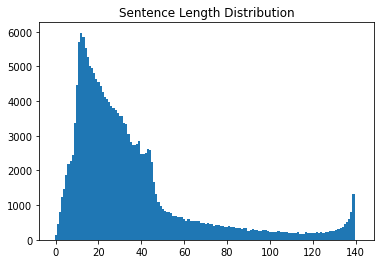

In [74]:
# 문장 길이 분포 시각화
sen_len = np.zeros((max_len), dtype=np.int32)

for sen in rm_dup['document']:
    sen_len[len(sen)-1] += 1

plt.bar(range(max_len), sen_len, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [75]:
def find_sentence_by_length(raw, length):
    count = 0
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

# 문장 길이가 1인 문장 확인
find_sentence_by_length(rm_dup['document'], 1)

굿
핡
휴
시
ㅋ
ㅇ
‥
O
갑
ㅎ
.
올
헷
g
♥
짱
ㅆ
굳
잼
ㅁ
?
애
흠
!
찜
b
,
1
9
♬
ㅗ
ㄳ
ㄴ
호
a
d
f
음
헐
캬
린
업
乃
ㅠ
;
·
k
움
ㄱ
쩜
-
군
ㅉ
훗
z
쨩
뿌
♡
하
h
ㅍ
꽉
토
귯
아
오
ㅣ
봐
웅
네
ㅂ
꿈
헉
와
뻑
걍
헝
우
즛
풉
4
쀍
ㄹ
삼
쒯
즐
함
0
진
악
풋
쩝
욜
ㄷ
흐
싫
ㅜ
잏
허
엿
쉣


In [76]:
# 문장 길이가 2인 문장 확인
find_sentence_by_length(rm_dup['document'], 2)

쵝오
최고
좋아
흐흐
개쩜
굳뜨
좋다
섬뜩
♥♥
ㅎㅎ
대박
잼슴
굳굳
10
ㄹㄹ
윤하
유쾌
긋~
잼남
박수
수작
굳!
졸잼
꿈.
쏘우
굿!
명작
대작
잼네
맞아
ㅇㅇ
완벽
오우
굿굿
ㅠㅠ
굿잡
와우
..
좋네
無言
미투
gg
ㅋㅋ
후훗
걸작
잼잼
나두
예뻐
^^
만점
웃김
오호
설리
좋너
의읭
감동
원작
구ㄷ
하하
좋음
조앙
멋져
매력
개박
조음
추천
탁월
조아
쩔어
감독
가슴
재밋
잼씀
진리
붉다
눈물
오오
9점
zz
잼따
1등
짱임
홧팅
쳐봐
신고
짱♥
ㅡㅡ
역시
뻥임
섹시
명품
우정
짱~
동참
짱짱
야한
ㅊㅊ
굿~
대단
반담
만족


In [77]:
# 문장 길이가 140인 문장 확인
find_sentence_by_length(rm_dup['document'], 140)

초반엔 황당한 설정이다 싶어 몰입이 힘들었지만 점차 이건 판타지가 아니라 우리의 근미래에 현실이 될지도 모르는 언론탄압에 대한 진지한 은유라는 생각이 들었다. 남자주인공 오카다 준이치는 예상보다 훨씬 좋았다. 별 기대없이 보았는데 의외의 재미와 감동.
개인적으로 재미있었습니다. 언제 팬텀이랑 크리스틴이랑 그런일이 있었는지 전혀 몰랐네요.... ㅠㅠㅠ 일반스토리들 처럼 크리스틴이 다시 남편 곁으로 돌아갔었더라면하는 아쉬움은 있네요 The Beauty Underneath가 젤 좋았어요 개인적으로 ㅋㅋㅋ
그냥 뮤직비디오 본다고 생각하면 훌륭한 작품이다. 동양인 비하라고 하는 분들에게 몇마디하자면 이 영화 자체가 디스를 통한 개그코드를 유지합니다. 남녀 비하, 유태인, 레즈비언, 오타쿠들 등등 동양인도 그소재중 하나지 동양비하가 본 목적은 아니에요 ㅋㅋ
나의 평점은 9점인데, 평균평점이 8점이라 10점으로 주겠다. 오페라 몇편을 감상한듯 전율이 이는 사운드와 자유를 갈망하는 민중의 패기 어린 웅장함이 가슴을 울렸다. 살짝 아쉬운 느낌이 들지만, 한편에 긴 대서사시를 이렇게 옮긴것만 해도 극찬받을만하다
선유야 사랑해 우리 좀있다가 보자!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!♥!!
진짜 평점주러 오는건 처음이다.2년전 영화를 지금 본게 너무 후회스럽다ㅜ진짜 주연배우들이 정말 너무 매력있고 스토리가 너무 잼있다.진짜 어제보고 오늘 또 본 영화는 처음이다.연애하고싶게만드는 영화였고 명대사들이 너무 좋은 영화였다@연애하기좋을날씨다~@
진실평점 8점이상 9점을 준건 평점을 끌어올기위해 10점은 너무 말이 안됨 그렇다고 7점대를 돌아다닐 영화가 아님 헐리웃을 개량하면서 유사한 영화들도 8점대는 다넘는데 이 영화가 못넘다니 조금 웃기고 불편한진실 너훈아가 나훈아만큼의 인기를 누린만큼이다
안개 속에서 균형을 잃고

In [78]:
rm_dup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194542 entries, 0 to 194541
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   index     194542 non-null  int64 
 1   id        194542 non-null  int64 
 2   document  194542 non-null  object
 3   label     194542 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.9+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


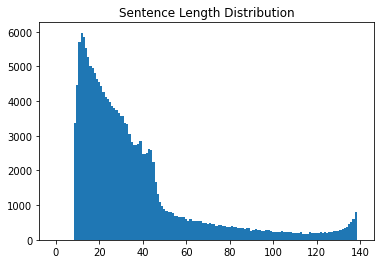

In [79]:
max_len = 140
min_len = 10

# 길이 조건에 맞는 문장만 선택
# filtered_corpus = [s for s in rm_dup['document'] if (len(s) < max_len) & (len(s) >= min_len)]
filtered_corpus = rm_dup[(rm_dup['document'].str.len() < max_len) & (rm_dup['document'].str.len() >= min_len)]

# 분포도를 다시 그림
sen_len = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus['document']:
    sen_len[len(sen)-1] += 1

plt.bar(range(max_len), sen_len, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

---

## **03. SentencePiece 학습**

In [80]:
# 토큰화
# 트레이닝 데이터
temp_file = '/content/mydrive/MyDrive/AIFFEL/GoingDeeper/GD01~02/tokenizer/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus['document']:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

# model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)


In [94]:
model = 'kor_spm_unigram_8k.model'
model2 = 'kor_spm_bpe_8k.model'

s = spm.SentencePieceProcessor()
s.Load(model)

s2 = spm.SentencePieceProcessor()
s2.Load(model2)

# test
target_sentence = '아버지가방에들어가신다'

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(target_sentence)
tokensIDs2 = s2.EncodeAsIds(target_sentence)
print(tokensIDs)
print(tokensIDs2)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(target_sentence,1, 0.0))
print(s2.SampleEncodeAsPieces(target_sentence,1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))
print(s2.DecodeIds(tokensIDs2))


[1391, 9, 384, 15, 1331, 9, 148, 17]
[4940, 862, 6552, 6299, 1405, 6295, 6396, 6289]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다']
['▁아버', '지가', '방', '에', '들어', '가', '신', '다']
아버지가방에들어가신다
아버지가방에들어가신다


unigram 8k가 조금 더 낫습니다.

---

## **04. Tokenizer 함수 생성**

In [95]:
def sp_tokenize(s, corpus, spm):
    tensor = []
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
    
    with open("./{}.vocab".format(spm), "r") as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

print("Done!")

Done!


In [96]:
# sp_tokenize(s, corpus, spm) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'kor_spm_unigram_8k')
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  579 2927   14 1378 2062    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  

---

## **05. nsmc 학습하기**

In [98]:
sp_tensor, sp_word_index, sp_index_word = sp_tokenize(s, filtered_corpus['document'], 'kor_spm_unigram_8k')

In [99]:
print(sp_tensor)

[[   0    0    0 ... 7261  780  139]
 [   0    0    0 ...   15 2370    4]
 [   0    0    0 ...    5  124    4]
 ...
 [   0    0    0 ...  150 1364    4]
 [   0    0    0 ... 1341 2568  121]
 [   0    0    0 ...  394  240  394]]


In [100]:
sp_word_index

{0: '<unk>',
 1: '<s>',
 2: '</s>',
 3: '▁',
 4: '.',
 5: '..',
 6: '이',
 7: '▁영화',
 8: '...',
 9: '가',
 10: '의',
 11: '도',
 12: '는',
 13: ',',
 14: '을',
 15: '에',
 16: '고',
 17: '다',
 18: '은',
 19: '지',
 20: '?',
 21: '한',
 22: '를',
 23: '▁너무',
 24: '만',
 25: '!',
 26: '▁이',
 27: '▁정말',
 28: '로',
 29: '게',
 30: '나',
 31: '▁진짜',
 32: '영화',
 33: '~',
 34: '과',
 35: '기',
 36: '어',
 37: '리',
 38: '하고',
 39: '라',
 40: '인',
 41: '으로',
 42: '아',
 43: '점',
 44: '네',
 45: '▁안',
 46: '에서',
 47: '▁잘',
 48: '서',
 49: '▁그',
 50: '와',
 51: '요',
 52: '들',
 53: '▁다',
 54: '▁왜',
 55: '하는',
 56: '▁1',
 57: '▁더',
 58: '▁수',
 59: '!!',
 60: '▁이런',
 61: '네요',
 62: '거',
 63: '해',
 64: '▁아',
 65: '....',
 66: '자',
 67: '면',
 68: '▁본',
 69: '▁그냥',
 70: '수',
 71: '음',
 72: '대',
 73: '스',
 74: '▁드라마',
 75: '지만',
 76: '하',
 77: '니',
 78: '시',
 79: '▁보고',
 80: '▁10',
 81: '하게',
 82: '▁연기',
 83: '야',
 84: '▁평점',
 85: '함',
 86: '▁내',
 87: '사',
 88: '▁영화를',
 89: '▁한',
 90: '일',
 91: '이다',
 92: '▁좀',
 93: '진',
 94: 

In [101]:
sp_index_word

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '▁': 3,
 '.': 4,
 '..': 5,
 '이': 6,
 '▁영화': 7,
 '...': 8,
 '가': 9,
 '의': 10,
 '도': 11,
 '는': 12,
 ',': 13,
 '을': 14,
 '에': 15,
 '고': 16,
 '다': 17,
 '은': 18,
 '지': 19,
 '?': 20,
 '한': 21,
 '를': 22,
 '▁너무': 23,
 '만': 24,
 '!': 25,
 '▁이': 26,
 '▁정말': 27,
 '로': 28,
 '게': 29,
 '나': 30,
 '▁진짜': 31,
 '영화': 32,
 '~': 33,
 '과': 34,
 '기': 35,
 '어': 36,
 '리': 37,
 '하고': 38,
 '라': 39,
 '인': 40,
 '으로': 41,
 '아': 42,
 '점': 43,
 '네': 44,
 '▁안': 45,
 '에서': 46,
 '▁잘': 47,
 '서': 48,
 '▁그': 49,
 '와': 50,
 '요': 51,
 '들': 52,
 '▁다': 53,
 '▁왜': 54,
 '하는': 55,
 '▁1': 56,
 '▁더': 57,
 '▁수': 58,
 '!!': 59,
 '▁이런': 60,
 '네요': 61,
 '거': 62,
 '해': 63,
 '▁아': 64,
 '....': 65,
 '자': 66,
 '면': 67,
 '▁본': 68,
 '▁그냥': 69,
 '수': 70,
 '음': 71,
 '대': 72,
 '스': 73,
 '▁드라마': 74,
 '지만': 75,
 '하': 76,
 '니': 77,
 '시': 78,
 '▁보고': 79,
 '▁10': 80,
 '하게': 81,
 '▁연기': 82,
 '야': 83,
 '▁평점': 84,
 '함': 85,
 '▁내': 86,
 '사': 87,
 '▁영화를': 88,
 '▁한': 89,
 '일': 90,
 '이다': 91,
 '▁좀': 92,
 '진': 93,
 '주':

정상적으로 잘 생성되었습니다.

---

## **06. 모델 train & test**

- 심플한 RNN 모델을 사용해보겠습니다.

In [102]:
# 데이터 분리
filtered_label = np.array(filtered_corpus['label'])
x_train, x_val, y_train, y_val = tts(sp_tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = tts(x_train, y_train, test_size=0.2)

In [103]:
# 모델 설계
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, 64, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(64))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          512000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 545,089
Trainable params: 545,089
Non-trainable params: 0
_________________________________________________________________


In [104]:
model_rnn.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [105]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# check = ModelCheckpoint('best_model_lstm.h1', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [106]:
epochs=20
batch_size=64

lstm_history = model_rnn.fit(x_train,
                             y_train,
                             epochs=epochs,
                             batch_size=batch_size,
                             validation_data=(x_val,y_val),
                             callbacks=early,
                             verbose=1)

Epoch 1/20
1804/1804 [==============================] - 20s 10ms/step - loss: 0.3870 - accuracy: 0.8244 - val_loss: 0.3372 - val_accuracy: 0.8521
Epoch 2/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.3023 - accuracy: 0.8698 - val_loss: 0.3230 - val_accuracy: 0.8578
Epoch 3/20
1804/1804 [==============================] - 18s 10ms/step - loss: 0.2662 - accuracy: 0.8851 - val_loss: 0.3260 - val_accuracy: 0.8593
Epoch 4/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2356 - accuracy: 0.9014 - val_loss: 0.3406 - val_accuracy: 0.8566
Epoch 5/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2076 - accuracy: 0.9135 - val_loss: 0.3712 - val_accuracy: 0.8552
Epoch 6/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.1775 - accuracy: 0.9267 - val_loss: 0.4153 - val_accuracy: 0.8516
Epoch 6: early stopping


unigram 8k를 사용한 모델은 val_accuracy 85%의 성능을 보여줍니다.

---

## **07. 다각도 성능 비교분석**

### unigram -> bpe

- unigram 8k를 사용해봤으니 bpe는 어떤지 보겠습니다.

In [118]:
sp_tensor, sp_word_index, sp_index_word = sp_tokenize(s2, filtered_corpus['document'], 'kor_spm_bpe_8k')

In [119]:
model_rnn2 = tf.keras.Sequential()
model_rnn2.add(tf.keras.layers.Embedding(vocab_size, 64, input_shape=(None,)))
model_rnn2.add(tf.keras.layers.LSTM(64))
model_rnn2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          512000    
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 545,089
Trainable params: 545,089
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_rnn2.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [121]:
epochs=20
batch_size=64

lstm_history2 = model_rnn2.fit(x_train,
                               y_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=(x_val,y_val),
                               callbacks=early,
                               verbose=1)

Epoch 1/20
1804/1804 [==============================] - 21s 11ms/step - loss: 0.3860 - accuracy: 0.8250 - val_loss: 0.3405 - val_accuracy: 0.8511
Epoch 2/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.3007 - accuracy: 0.8696 - val_loss: 0.3195 - val_accuracy: 0.8604
Epoch 3/20
1804/1804 [==============================] - 20s 11ms/step - loss: 0.2630 - accuracy: 0.8882 - val_loss: 0.3225 - val_accuracy: 0.8608
Epoch 4/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2305 - accuracy: 0.9036 - val_loss: 0.3395 - val_accuracy: 0.8577
Epoch 5/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.1955 - accuracy: 0.9204 - val_loss: 0.3692 - val_accuracy: 0.8559
Epoch 6/20
1804/1804 [==============================] - 18s 10ms/step - loss: 0.1640 - accuracy: 0.9339 - val_loss: 0.4232 - val_accuracy: 0.8457
Epoch 6: early stopping


고점은 bpe 8k가 더 높지만, unigram 8k가 더 안정적으로 성능을 뽑아줍니다.

---

### vocab 사이즈 변경

In [122]:
with open(temp_file, 'w') as f:
    for row in filtered_corpus['document']:   # 이전 스텝에서 정제했던 corpus를 활용
        f.write(str(row) + '\n')

# model_type=unigram
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_unigram_16k --vocab_size={}'.format(temp_file, vocab_size*2)    
)

# model_type=bpe
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=kor_spm_bpe_16k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size*2)    
)


In [123]:
model3 = 'kor_spm_unigram_16k.model'
model4 = 'kor_spm_bpe_16k.model'

s3 = spm.SentencePieceProcessor()
s3.Load(model3)

s4 = spm.SentencePieceProcessor()
s4.Load(model4)

# SentencePiece를 활용한 sentence -> encoding
tokensIDs3 = s3.EncodeAsIds(target_sentence)
tokensIDs4 = s4.EncodeAsIds(target_sentence)
print(tokensIDs3)
print(tokensIDs4)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s3.SampleEncodeAsPieces(target_sentence,1, 0.0))
print(s4.SampleEncodeAsPieces(target_sentence,1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s3.DecodeIds(tokensIDs3))
print(s4.DecodeIds(tokensIDs4))

[7553, 438, 15, 9471, 197, 19]
[7631, 11655, 1405, 14295, 13650]
['▁아버지가', '방', '에', '들어가', '신', '다']
['▁아버지가', '방에', '들어', '가', '신다']
아버지가방에들어가신다
아버지가방에들어가신다


In [124]:
sp_tensor, sp_word_index, sp_index_word = sp_tokenize(s3, filtered_corpus['document'], 'kor_spm_unigram_16k')

In [125]:
model_rnn3 = tf.keras.Sequential()
model_rnn3.add(tf.keras.layers.Embedding(vocab_size, 64, input_shape=(None,)))
model_rnn3.add(tf.keras.layers.LSTM(64))
model_rnn3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 64)          512000    
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 545,089
Trainable params: 545,089
Non-trainable params: 0
_________________________________________________________________


In [126]:
model_rnn3.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [127]:
epochs=20
batch_size=64

lstm_history3 = model_rnn3.fit(x_train,
                               y_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=(x_val,y_val),
                               callbacks=early,
                               verbose=1)

Epoch 1/20
1804/1804 [==============================] - 20s 10ms/step - loss: 0.3871 - accuracy: 0.8260 - val_loss: 0.3382 - val_accuracy: 0.8504
Epoch 2/20
1804/1804 [==============================] - 18s 10ms/step - loss: 0.3032 - accuracy: 0.8699 - val_loss: 0.3240 - val_accuracy: 0.8591
Epoch 3/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2638 - accuracy: 0.8882 - val_loss: 0.3368 - val_accuracy: 0.8562
Epoch 4/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2323 - accuracy: 0.9027 - val_loss: 0.3416 - val_accuracy: 0.8593
Epoch 5/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.2005 - accuracy: 0.9183 - val_loss: 0.3687 - val_accuracy: 0.8537
Epoch 6/20
1804/1804 [==============================] - 19s 10ms/step - loss: 0.1688 - accuracy: 0.9318 - val_loss: 0.3956 - val_accuracy: 0.8503
Epoch 6: early stopping


In [128]:
sp_tensor, sp_word_index, sp_index_word = sp_tokenize(s4, filtered_corpus['document'], 'kor_spm_bpe_16k')

In [129]:
model_rnn4 = tf.keras.Sequential()
model_rnn4.add(tf.keras.layers.Embedding(vocab_size, 64, input_shape=(None,)))
model_rnn4.add(tf.keras.layers.LSTM(64))
model_rnn4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_rnn4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          512000    
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 545,089
Trainable params: 545,089
Non-trainable params: 0
_________________________________________________________________


In [130]:
model_rnn4.compile(optimizer='adam',
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

In [131]:
epochs=20
batch_size=64

lstm_history4 = model_rnn4.fit(x_train,
                               y_train,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_data=(x_val,y_val),
                               callbacks=early,
                               verbose=1)

Epoch 1/20
1804/1804 [==============================] - 24s 12ms/step - loss: 0.3975 - accuracy: 0.8165 - val_loss: 0.3403 - val_accuracy: 0.8507
Epoch 2/20
1804/1804 [==============================] - 23s 13ms/step - loss: 0.3100 - accuracy: 0.8668 - val_loss: 0.3298 - val_accuracy: 0.8542
Epoch 3/20
1804/1804 [==============================] - 20s 11ms/step - loss: 0.2720 - accuracy: 0.8850 - val_loss: 0.3285 - val_accuracy: 0.8583
Epoch 4/20
1804/1804 [==============================] - 21s 12ms/step - loss: 0.2404 - accuracy: 0.8992 - val_loss: 0.3477 - val_accuracy: 0.8565
Epoch 5/20
1804/1804 [==============================] - 23s 12ms/step - loss: 0.2105 - accuracy: 0.9138 - val_loss: 0.3555 - val_accuracy: 0.8498
Epoch 6/20
1804/1804 [==============================] - 21s 12ms/step - loss: 0.1815 - accuracy: 0.9262 - val_loss: 0.4105 - val_accuracy: 0.8488
Epoch 7/20
1804/1804 [==============================] - 23s 13ms/step - loss: 0.1506 - accuracy: 0.9400 - val_loss: 0.4348 -

### **시각화**

- 각 결과를 시각화하여 살펴보겠습니다.

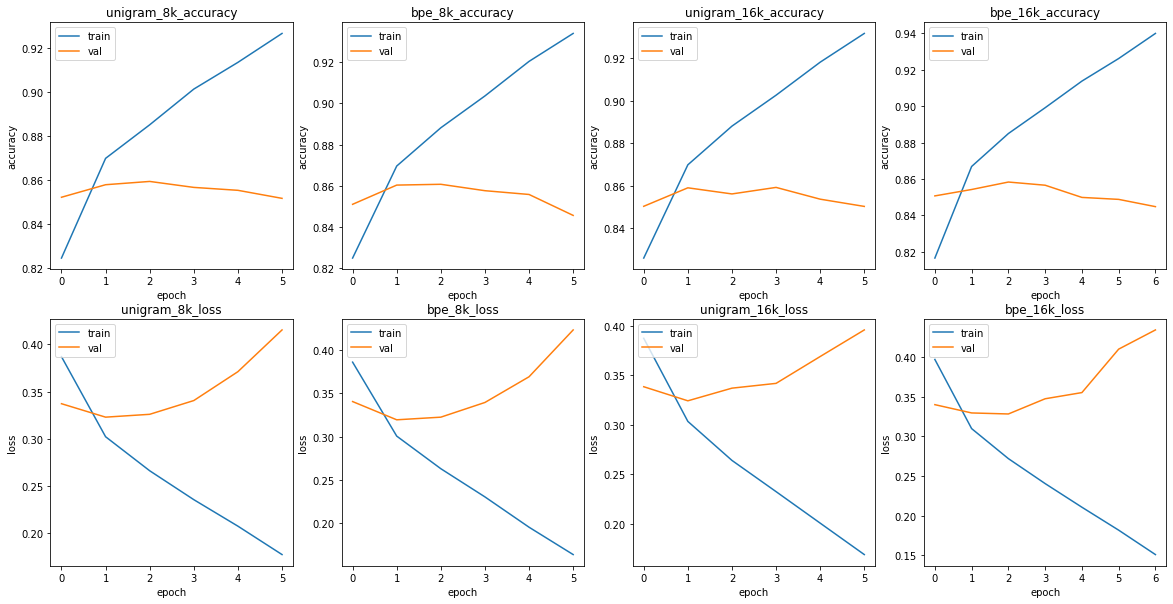

In [137]:
plt.figure(figsize = (20, 10))

## unigram 8k
# accuracy
model_name = 'unigram_8k'
plt.subplot(2,4,1)
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('{}_accuracy'.format(model_name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(2,4,5)
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('{}_loss'.format(model_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


## bpe 8k
# accuracy
model_name = 'bpe_8k'
plt.subplot(2,4,2)
plt.plot(lstm_history2.history['accuracy'])
plt.plot(lstm_history2.history['val_accuracy'])
plt.title('{}_accuracy'.format(model_name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(2,4,6)
plt.plot(lstm_history2.history['loss'])
plt.plot(lstm_history2.history['val_loss'])
plt.title('{}_loss'.format(model_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


## unigram 16k
# accuracy
model_name = 'unigram_16k'
plt.subplot(2,4,3)
plt.plot(lstm_history3.history['accuracy'])
plt.plot(lstm_history3.history['val_accuracy'])
plt.title('{}_accuracy'.format(model_name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(2,4,7)
plt.plot(lstm_history3.history['loss'])
plt.plot(lstm_history3.history['val_loss'])
plt.title('{}_loss'.format(model_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')


## bpe 16k
# accuracy
model_name = 'bpe_16k'
plt.subplot(2,4,4)
plt.plot(lstm_history4.history['accuracy'])
plt.plot(lstm_history4.history['val_accuracy'])
plt.title('{}_accuracy'.format(model_name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# loss
plt.subplot(2,4,8)
plt.plot(lstm_history4.history['loss'])
plt.plot(lstm_history4.history['val_loss'])
plt.title('{}_loss'.format(model_name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

전반적으로 봤을 때는 unigram 16k가 val_loss도 제일 적고 val_accuracy도 비교적 안정적으로 수렴합니다.

각 결과를 표로 나타내면 아래와 같습니다.

model | acc | loss |
:--|:--|:--
uni 8k | 0.8516 | 0.4153
uni 16k | 0.8503 | 0.3956
bpe 8k | 0.8457 | 0.4232
bpe 16k | 0.8448 | 0.4348

## **08. 회고**

- 따로 찾아보니 Byte Pair Encodding은 단어를 사전 크기만큼 쌓아가는 반면, unigram은 매우 큰 크기의 base vocabulary를 크게 잡고 likehood를 가지고 단어장을 갱신하는 방식이라고 합니다.

- 생각컨대 unigram의 voca size가 커질수록 loss값이 줄어드는 이유는 그만큼 여러 단어를 넓게 볼 수 있기 때문이고 BPE의 voca size가 커지면 loss와 acc가 모두 줄어드는 이유는 단어 사전의 크기 제한에 영향을 많이 받기 때문인 것 같습니다.

- 결론적으로 적절한 성능을 내기 위해 토큰화해야하는 단어가 많다면 unigram, 단어가 적고 비교적 분포가 극단적이지 않다면 BPE를 쓰는 게 좋을 것 같습니다.